## 눈동자 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

### ImageDataGenerator 읽기

In [2]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


### 제너레이터
- 참고 : [제너레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)

In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

### 제너레이터로 데이터 포인트 확인

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.        0.        1.        1.        0.6091986 0.49375  ]
(80, 120, 3) [0.         0.         1.         1.         0.6958333  0.15605159]


/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


## 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계


## tf.keras.Sequential()

In [5]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='sigmoid')
])

(32, 2048)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [8]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [9]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 25s 31ms/step - loss: 0.0297 - mae: 0.0887
Epoch 2/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0143 - mae: 0.0560
Epoch 3/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0138 - mae: 0.0546
Epoch 4/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0133 - mae: 0.0533
Epoch 5/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0131 - mae: 0.0527
Epoch 6/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0129 - mae: 0.0524
Epoch 7/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0129 - mae: 0.0523
Epoch 8/10
741/741 [==============================] - 18s 24ms/step - loss: 0.0128 - mae: 0.0520
Epoch 9/10
741/741 [==============================] - 17s 24ms/step - loss: 0.0129 - mae: 0.0521
Epoch 10/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0127 - mae: 0.0516


## 키포인트 검출 딥러닝 모델 만들기 (3) 평가

### 검증(validation)용 데이터

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2634 images belonging to 1 classes.
Found 2634 images belonging to 1 classes.


### generator()

In [11]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012638009153306484 0.05211144685745239


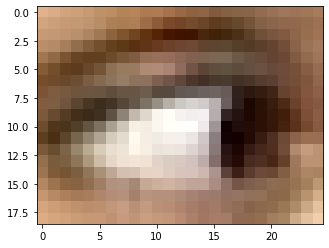

In [12]:
# img test
import cv2
import matplotlib.pyplot as plt

'''
000070
'''

img = cv2.imread(val_data_root+'/img/eye_000070_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.61876715e-08 2.27739702e-06]
  [1.19999886e+02 7.99946747e+01]
  [5.87482986e+01 2.40653820e+01]]]


## pt = 0.4

[0. 0.]
[120.  80.]
[59. 24.]


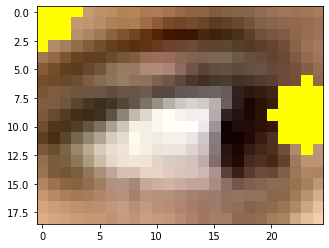

In [14]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.4).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴사진 넣기

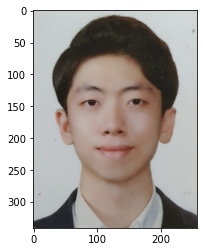

In [20]:
img2 = cv2.imread(val_data_root+'/img/face.jpg')
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
np_inputs = np.expand_dims(cv2.resize(img2, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[4.1803862e-03 1.4453112e-02]
  [1.1999754e+02 7.9999771e+01]
  [7.1002319e+01 3.0616077e+01]]]


[0. 0.]
[120.  80.]
[71. 31.]


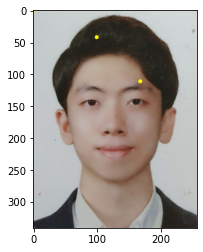

In [29]:
show = img2.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*1.4).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

In [35]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

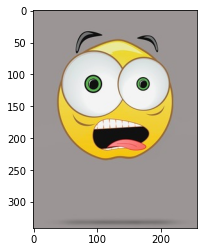

In [33]:
emoji = cv2.imread(val_data_root+'/img/emoji.jpg')
plt.imshow(cv2.cvtColor(emoji , cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
emoji_face = visualize_cam_on_image(show, emoji)

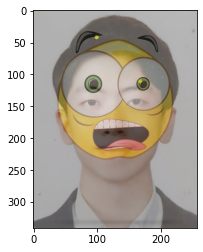

In [37]:
plt.imshow(cv2.cvtColor(emoji_face, cv2.COLOR_BGR2RGB))
plt.show()

## 마치며...
- 눈 좌표를 검출하는 방법이 여러가지가 있다는 것을 알 수 있었다.

### 루브릭 평가
1. mean-shift를 활용하여 눈동자 검출 라벨링 추가작업을 원활히 진행하였다.
- 눈이미지-라벨이미지 쌍의 추가데이터셋을 10000건 이상 충분히 확보하였다.

2. 눈동자 키포인트 검출 딥러닝 모델이 구현되어 안정적으로 학습이 진행되었다.
- pretrained model 기반의 딥러닝 모델의 트레이닝 loss가 안정적으로 감소함을 확인하였다.

3. 모델이 검출한 눈 위치에 당황한 표정효과 눈 이미지를 합성한 이미지를 생성하였다.
- 사람 얼굴 이미지에서 딥러닝 모델로 눈동자 키포인트를 검출하여 눈 이미지를 자연스럽게 합성한 결과이미지를 생성하였다.